In [1]:
from mlx_lm import load, generate
import pandas as pd
import numpy as np
import textwrap
from pprint import pprint

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [72]:
model, tokenizer = load("mlx-community/quantized-gemma-2b")

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 49152.00it/s]


In [75]:
response = generate(model, tokenizer, prompt="What is a Glaucoma",verbose=True,max_tokens=128)

Prompt: What is a Glaucoma
?

Glaucoma is a condition that affects the optic nerve, which is the nerve that transmits information from the eye to the brain. The optic nerve is located in the back of the eye and transmits information from the retina to the brain. The retina is the light sensitive layer of tissue that lines the back of the eye.

Glaucoma is a condition that affects the optic nerve and causes it to become damaged. This damage can cause vision loss and other problems. Glaucoma is a common condition that affects people of all ages. It is usually caused by a build-up of fluid in the eye, which can cause pressure on
Prompt: 71.798 tokens-per-sec
Generation: 123.945 tokens-per-sec


In [5]:
df = pd.read_csv('intern_screening_dataset.csv')
df.head()

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl..."


## Formatting promp to match what Gemma was trained on:

` {"text": "<bos><start_of_turn>user\nWhat are the symptoms of Glaucoma?<end_of_turn>\n<start_of_turn>model\nGlaucoma symptoms include blurred vision, eye pain, headache andnausea.<end_of_turn><eos>"} `

In [6]:
#To format into an input gemma can understand better
def generate_prompt(row: pd.Series) -> str: 
    return """<bos><start_of_turn>user
## User
{}<end_of_turn>
<start_of_turn>model
{}<end_of_turn><eos>""".format(row["question"], row["answer"])


df["text"] = df.apply(generate_prompt, axis=1)

#Example model training input
print(df["text"].iloc[0])

<bos><start_of_turn>user
## User
What is (are) Glaucoma ?<end_of_turn>
<start_of_turn>model
Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. The most common form of the disease is open-angle glaucoma. With early treatment, you can often protect your eyes against serious vision loss. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.)  See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more.  See a glossary of glaucoma terms.<end_of_turn><eos>


Saving data in two separate jsonl formatted files to feed into LORA training

In [12]:
from pathlib import Path

Path("data").mkdir(exist_ok=True)

split_ix = int(len(df) * 0.9)
# shuffle data
data = df.sample(frac=1, random_state=42)
train, valid = data[:split_ix], data[split_ix:]

train[["text"]].to_json("data/train.jsonl", orient="records", lines=True, force_ascii=False)
valid[["text"]].to_json("data/valid.jsonl", orient="records", lines=True, force_ascii=False)

!head -n 1 data/train.jsonl

{"text":"<bos><start_of_turn>user\n## User\nIs Juvenile Huntington disease inherited ?<end_of_turn>\n<start_of_turn>model\nHow is Juvenile Huntington disease (HD) inherited? Juvenile HD is inherited in an autosomal dominant manner, which means that one copy of the altered gene in each cell is sufficient to cause the disorder. An affected person usually inherits the altered gene from one affected parent. As the altered HTT gene is passed from one generation to the next, the size of the CAG trinucleotide repeat often increases in size. A larger number of repeats is usually associated with an earlier onset of signs and symptoms (anticipation). A larger number of repeats is usually associated with an earlier onset of signs and symptoms. Most often, children with juvenile HD inherit the expanded CAG trinucleotide repeat from their fathers, although on occasion they inherit it from their mothers.<end_of_turn><eos>"}


## Using MLX LORA to fine tune quantized-gemma-2b on our medical datatset

In [13]:
!python3.11 -m mlx_lm.lora \
    --model mlx-community/quantized-gemma-2b \
    --train \
    --iters 600 \
    --data data \
    --batch-size 1 \
    --lora-layers 4 \


Loading pretrained model
Fetching 6 files: 100%|████████████████████████| 6/6 [00:00<00:00, 71493.82it/s]
Loading datasets
Training
Trainable parameters: 0.008% (0.205M/2506.172M)
Starting training..., iters: 600
Iter 1: Val loss 2.247, Val took 4.935s
Iter 10: Train loss 2.416, Learning Rate 1.000e-05, It/sec 3.374, Tokens/sec 875.431, Trained Tokens 2595, Peak mem 5.258 GB
Iter 20: Train loss 2.365, Learning Rate 1.000e-05, It/sec 2.583, Tokens/sec 757.246, Trained Tokens 5527, Peak mem 6.076 GB
Iter 30: Train loss 2.262, Learning Rate 1.000e-05, It/sec 2.183, Tokens/sec 804.974, Trained Tokens 9214, Peak mem 7.665 GB
Iter 40: Train loss 2.306, Learning Rate 1.000e-05, It/sec 3.489, Tokens/sec 750.558, Trained Tokens 11365, Peak mem 7.665 GB
Iter 50: Train loss 2.138, Learning Rate 1.000e-05, It/sec 2.419, Tokens/sec 787.714, Trained Tokens 14621, Peak mem 8.561 GB
Iter 60: Train loss 2.298, Learning Rate 1.000e-05, It/sec 2.407, Tokens/sec 791.520, Trained Tokens 17909, Peak mem 8.5

In [8]:
val_losses = [
    2.247, #iter 1
    1.813, #iter 200
    1.708, #iter 400
    1.637  #iter 600
]
train_losses = [
    2.416,  # Iter 10
    2.365,  # Iter 20
    2.262,  # Iter 30
    2.306,  # Iter 40
    2.138,  # Iter 50
    2.298,  # Iter 60
    2.269,  # Iter 70
    2.074,  # Iter 80
    2.140,  # Iter 90
    2.162,  # Iter 100
    2.035,  # Iter 110
    2.057,  # Iter 120
    2.156,  # Iter 130
    1.891,  # Iter 140
    1.997,  # Iter 150
    2.064,  # Iter 160
    1.961,  # Iter 170
    1.962,  # Iter 180
    1.931,  # Iter 190
    1.913,  # Iter 200
    1.886,  # Iter 210
    1.764,  # Iter 220
    1.870,  # Iter 230
    1.713,  # Iter 240
    1.851,  # Iter 250
    1.776,  # Iter 260
    1.912,  # Iter 270
    1.918,  # Iter 280
    1.900,  # Iter 290
    1.646,  # Iter 300
    1.891,  # Iter 310
    1.947,  # Iter 320
    1.762,  # Iter 330
    1.818,  # Iter 340
    1.718,  # Iter 350
    1.784,  # Iter 360
    1.796,  # Iter 370
    1.746,  # Iter 380
    1.759,  # Iter 390
    1.923,  # Iter 400
    1.741,  # Iter 410
    1.723,  # Iter 420
    1.651,  # Iter 430
    1.686,  # Iter 440
    1.702,  # Iter 450
    1.818,  # Iter 460
    1.653,  # Iter 470
    1.623,  # Iter 480
    1.763,  # Iter 490
    1.643,  # Iter 500
    1.787,  # Iter 510
    1.905,  # Iter 520
    1.813,  # Iter 530
    1.619,  # Iter 540
    1.694,  # Iter 550
    1.765,  # Iter 560
    1.802,  # Iter 570
    1.698,  # Iter 580
    1.689,  # Iter 590
    1.547,  # Iter 600
]

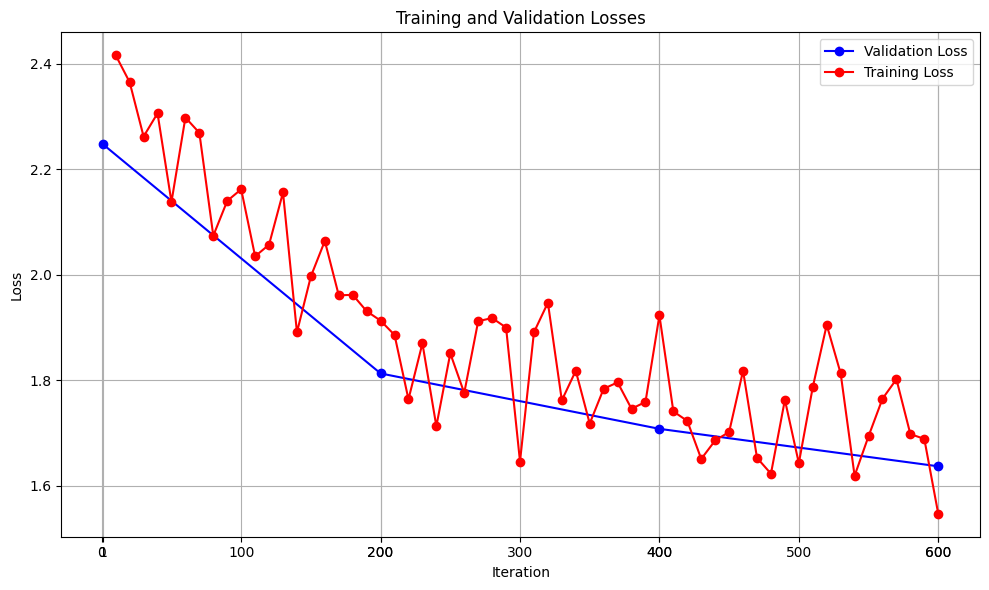

In [9]:
import matplotlib.pyplot as plt

val_iters = [1, 200, 400, 600]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(val_iters, val_losses, marker='o', linestyle='-', color='b', label='Validation Loss')
plt.plot(range(10, 601, 10), train_losses, marker='o', linestyle='-', color='r', label='Training Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(val_iters + list(range(0, 601, 100)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
#command line prompt
!python3.11 -m mlx_lm.generate --model "mlx-community/quantized-gemma-2b" \
               --adapter-path adapters \
               --max-tokens 128 \
               --prompt "What is (are) Glaucoma ?" \
#Final weights are saved in the adaptors directory

Fetching 6 files: 100%|████████████████████████| 6/6 [00:00<00:00, 64693.63it/s]
Prompt: What is (are) Glaucoma ?
 Glaucoma is a common eye condition that affects millions of people worldwide. It occurs when the optic nerve is damaged, usually due to high eye pressure. This can result in vision changes, such as blurred vision, halos around lights, and blind spots. Glaucoma is usually caused by an increase in eye pressure, which can be caused by a variety of factors, including age, race, family history, eye surgery, and eye trauma. While glaucoma can affect people of all ages, it is more common in people over the age of 50. This is because the optic nerve is especially susceptible to damage as we age.
Prompt: 70.535 tokens-per-sec
Generation: 117.065 tokens-per-sec


In [9]:
model_lora, tokenizer = load(
    "mlx-community/quantized-gemma-2b",
    adapter_path="./adapters", 
)
#Final weights of finetuned model are saved in the adaptors directory

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 83330.54it/s]


In [10]:
def generate_output(prompt):
    response = generate(model_lora, tokenizer, prompt=prompt,temp=0.5)
    response = textwrap.fill(response, width=120)
    print(response)
    return 

In [6]:
generate_output("What is Glaucoma ?")

 Glaucoma is a common eye condition that can cause vision loss or blindness if not treated. Glaucoma occurs when the
optic nerve is damaged due to increased eye pressure. It is usually caused by a narrowing of the drainage canals in the
eye. This condition is caused by an increase in eye pressure called intraocular pressure (IOP). Intraocular pressure is
caused by several factors including aging, race, gender, lifestyle habits, and medical conditions. Intraocular pressure
can increase due to aging, race, gender,


In [79]:
generate_output('What is Leukemia ?')

 Leukemia is a cancer of the blood and bone marrow. It is a malignant tumor that originates in the bone marrow and
spreads to the blood vessels. It is a rare disease that affects people of all ages, but it is more common in children
and young adults. It is a disease that affects the bone marrow and blood cells. It is a disease that affects the bone
marrow and blood cells. It is a disease that affects the bone marrow and blood cells. It is a disease that affects the


In [82]:
generate_output('What is Diabetic Retinopathy ?')

 Diabetic Retinopathy is a condition that affects the blood vessels in the retina, the light-sensitive tissue at the
back of the eye. Diabetic Retinopathy is a common complication of diabetes mellitus. Diabetic Retinopathy is a condition
that affects the blood vessels in the retina, the light-sensitive tissue at the back of the eye. Diabetic Retinopathy is
a common complication of diabetes mellitus. Diabetic Retinopathy is a condition that affects the blood vessels in the
retina, the light-sensitive


In [88]:
generate_output('What are the symptoms of depression')

? Depression affects people differently, but there are some common symptoms. If you have depression, you may experience
changes in your sleep patterns, appetite, energy level, or concentration. Some people also experience unexplained
physical symptoms such as headaches or stomach aches. Depression can also cause you to feel hopeless, helpless, or
worthless. If you have depression, you may feel like you don't belong or that your life doesn't have meaning. Depression
can also cause you to have suicidal thoughts or feelings. If


# Fusing Model Weights, Uploading to Hugging Face, and Performing Inference

In [ ]:
!python3.11 -m mlx_lm.fuse \
    --model mlx-community/quantized-gemma-2b \
    --adapter-path adapters \
    --upload-repo Arjun24420/Medical-quantized-gemma-2b \
    --hf-path mlx-community/quantized-gemma-2b

#Output
Loading pretrained model
Fetching 6 files: 100%|████████████████████████| 6/6 [00:00<00:00, 51254.22it/s]
README.md: 100%|███████████████████████████████| 914/914 [00:00<00:00, 3.30MB/s]
/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/utils/_experimental.py:58: UserWarning: 'plan_multi_commits' is experimental and might be subject to breaking changes in the future. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/utils/_experimental.py:58: UserWarning: 'HfApi.create_commits_on_pr' is experimental and might be subject to breaking changes in the future. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
Will create 0 deletion commit(s) and 2 addition commit(s), totalling 7 atomic operations.
Multi-commits strategy with ID 501436a069524ecb0b96f94115b3d686824b617f8774e082fdcbf502db68f8fc.
New PR created: https://huggingface.co/Arjun24420/Medical-quantized-gemma-2b/discussions/1
model.safetensors: 100%|███████████████████| 2.16G/2.16G [05:26<00:00, 6.63MB/s]
  step ead2ff05886ee726132cbe44521298fd90fcc9fad3d5d1bf070a7e384819f23f completed (still 1 to go).
tokenizer.json: 100%|██████████████████████| 17.5M/17.5M [00:02<00:00, 7.09MB/s]
  step eb8be3356eaf08a4cc9f1a2ebec73e317af8934b08f50a53641a0722adac2778 completed (still 0 to go).
All commits have been pushed.
PR is now open for reviews.
PR has been automatically merged (`merge_pr=True` was passed).
Upload successful, go to https://huggingface.co/Arjun24420/Medical-quantized-gemma-2b for details.

In [70]:
#only available on my local machine as model was too big to push to github (Hugging face usage given below)
fused_model, fused_tokenizer = load("./lora_fused_model/") 
def generate_FusedModel_output(prompt):
    response = generate(fused_model, fused_tokenizer, prompt=prompt,temp=0.9)
    response = textwrap.fill(response, width=120)
    print(response)
    return 

In [71]:
generate_FusedModel_output("Who is at risk of Colorectal Cancer ")

  Colorectal cancer is the third most common cancer for both genders. Most people have several genetic traits that place
them at a higher risk of developing colorectal cancer. For example, several metabolic disorders are linked to a higher
risk of colorectal cancer. These include:  * Inflammatory bowel disease * Genetic syndromes * Nutrient deficiencies *
Metabolic disorders * Inherited genetic disorders  Other risk factors for colorectal cancer include:  * Obesity *
Inactive lifestyle * Smoking * Diet rich in processed and


## Hugging Face sample use

In [28]:
from mlx_lm import load, generate

model, tokenizer = load("Arjun24420/Medical-quantized-gemma-2b")

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 59353.36it/s]


In [60]:
response = generate(model, tokenizer, prompt="What is glaucoma",temp=0.5)
response = textwrap.fill(response, width=120)
print(response)

 and what causes it?  Glaucoma is a disease that affects the optic nerve in the eye. It is caused by the buildup of
fluid in the eye. This causes the optic nerve to swell and eventually die. The loss of the optic nerve leads to vision
loss.  What are the signs and symptoms of glaucoma? Glaucoma can cause a variety of symptoms. These include: • Blurred
vision • Blindness • Frequent eye pain • Nausea and vomiting •
